# Cell Tracking (Project 6)

**Group 12: Maximilian Karhausen, Johannes Simon**

**Background:** When testing a pharmacological drug onto cells, the effect on the cell population growth and 
overall phenotype is usually assessed by a single snapshot image. While these population and 
time-averaged measurements can highlight big scale effects between cell populations and 
conditions, they are an indirect measure of responses to chemotherapeutic drugs. Another 
approach is to record long videos of these cell populations while subjected to the drugs. These 
live observations are more accurate in capturing the proliferation behavior than standard 
approaches. Manual tracking of each single cell in the visual field is very time-consuming.

**Approach:** Given pre-detected cancer cells (in COCO format), we investigate suitable methods to match detections across frames (tracking). To do this, we compare the tracking methods SORT and DeepSORT with each other.

In [3]:
# ensuring that plots are rendered inline
%matplotlib inline

# Get all necessary imports
import json
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from collections import defaultdict
from sort.sort import Sort
import numpy as np

## Part 1: Load the dataset and classify the cells

In [4]:
# Initialize local paths
# Dataset path
# Hint: (change to "/scratch/cv-course/jsimon10/dataset_jpg/dataset" when working on RAMSES)
DATASET_DIR = Path("dataset_jpg/dataset")
# Annotations file path
ANN_FILE = DATASET_DIR / "annotations.json"
# Create folder for cropped cells, needed later to train appearance model for DeepSORT
CROP_DIR = Path("cell_crops")
CROP_DIR.mkdir(exist_ok=True)

In [5]:
# Load the COCO annotations from the annotations.json file
with ANN_FILE.open("r") as f:
    coco = json.load(f)
# Get category name by their ID
cat_name_by_id = {cat["id"]: cat["name"] for cat in coco["categories"]}
# Group all annotations by their image ID to find all cells for each image more easily
annots_by_img = {}
for ann in coco["annotations"]:
    annots_by_img.setdefault(ann["image_id"], []).append(ann)
# Group all images by their ID to find them more faster
img_by_id = {}
for img in coco["images"]:
    img_by_id[img["id"]] = img
# Print summary info on the dataset once loaded
print("Loaded dataset with:")
print(f"  - {len(coco['images'])} images")
print(f"  - {len(coco['annotations'])} annotations")
print(f"  - {len(coco['categories'])} categories:")
for cat_id, cat_name in cat_name_by_id.items():
    print(f"    ID {cat_id}: {cat_name}")

Loaded dataset with:
  - 40350 images
  - 2204912 annotations
  - 2 categories:
    ID 1: living_cell
    ID 2: dead_cell


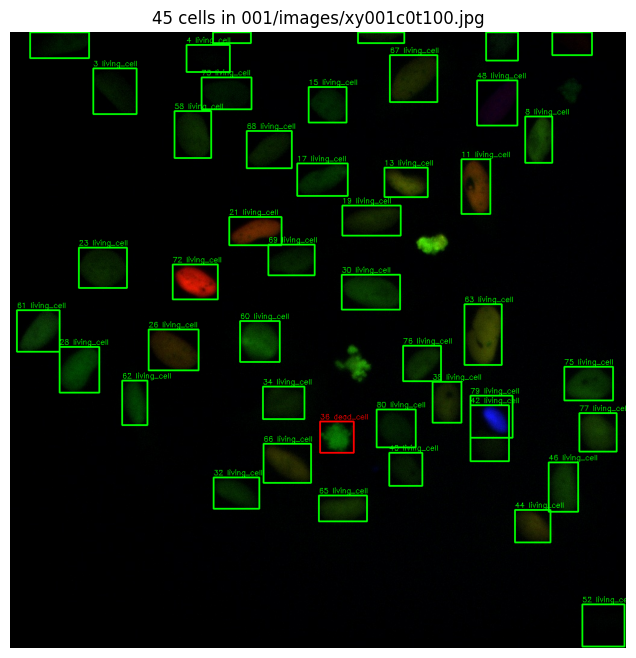

In [6]:
%matplotlib inline
# Get an image by an selected index for visualization
img_example = img_by_id[100] # For testing, only index of 0-449 works. Original dataset: up to 40349
# Get the path to the image
img_path = DATASET_DIR / img_example["file_name"]
# Raise an error if image does not exist
if not img_path.exists():
    raise FileNotFoundError(f"Image file not found: {img_path}")
# Load the image and turn from BGR to RGB
img_rgb = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
# Get annotations for the selected image
annots = annots_by_img.get(img_example["id"], [])
# Apply different colors for bounding boxes of different classes
bbox_color_map = {
    "living_cell": (0, 255, 0),     # green for living cell
    "dead_cell": (255, 0, 0),     # red for dead cell
}
# Draw bounding boxes based on annotations
for i, ann in enumerate(annots):
    # Get center x and y coordinates of the bounding box with width and height
    x_center, y_center, width, height = ann["bbox"]
    # For correct drawing (and SORT later), convert center-based x and y coordinates to top-left
    x, y = x_center - width / 2, y_center - height / 2
    # For correct drawing, turn float values to int values - OpenCV expects int values
    x_draw, y_draw, width_draw, height_draw = int(x), int(y), int(width), int(height)
    # Get the classified category
    cat_id = ann["category_id"]
    # Get the respective category name
    cat_name = cat_name_by_id.get(cat_id, "unknown") # Edge case: If annotation without category exist, label as "unknown"
    # Construct label with cell ID and category name, e.g. 30 living_cell
    label = f"{ann['cell_id']} {cat_name}"
    # Get the respective color of bounding box
    color = bbox_color_map.get(cat_name, (255, 255, 255)) # Edge case: If annotation without category exist, color white
    # Draw the bounding boxes and the text with the classified category 
    cv2.rectangle(img_rgb, (x_draw, y_draw), (x_draw + width_draw, y_draw + height_draw), color, 2)
    cv2.putText(img_rgb, label, (x_draw, y_draw - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
# Show classification result
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"{len(annots)} cells in {img_example['file_name']}")
plt.show()

## Part 2: Prepare the data to train the appearance model of DeepSORT

In [7]:
# Get all folder names in a sorted list
#all_folders = sorted([f.name for f in DATASET_DIR.iterdir() if f.is_dir()])
all_folders = ["001", "002", "003"] # REMOVE THIS FOR ORIGINAL DATASET
# Ensure reproducibility with same sequence of random folders
random.seed(30)
# Shuffle the list of folders randomly
random.shuffle(all_folders)
# Split the folders by 80% for training (with cropped cells) and 20% testing (for tracking)
split_idx = int(0.8 * len(all_folders))
train_folders = set(all_folders[:split_idx])
test_folders = set(all_folders[split_idx:])
# Crop cells for all annotations
for ann in coco["annotations"]:
    # Get image from current annotation
    img = img_by_id[ann["image_id"]]
    # Get image path of given image
    img_path = DATASET_DIR / img["file_name"]
    # Get ID of folder, e.g. 001
    folder = Path(img["file_name"]).parts[0]
    # Skip folders that are not selected for training
    if folder not in train_folders:
        continue
    # Load the image in BGR format
    img_bgr = cv2.imread(str(img_path))
    # Get center x and y coordinates of the bounding box with width and height
    x_center, y_center, width, height = ann["bbox"]
    # Get image bounds of the cell
    x0, y0, x1, y1 = int(x_center - width / 2), int(y_center - height / 2), int(x_center + width / 2), int(y_center + height / 2)
    # Get actual height and width of the original image
    img_height, img_width = img_bgr.shape[:2]
    # Skip all edge-cut cells
    if (x0 <= 0 or y0 <= 0 or x1 >= img_width or y1 >= img_height):
        continue
    # Define unique ID as video ID and cell ID for folder, e.g. 001_001
    id = f"{ann['video_id']:03d}_{ann['cell_id']:03d}"
    # Get the classified category
    cat_id = ann["category_id"]
    # Get the respective category name
    cat_name = cat_name_by_id.get(cat_id, "unknown") # Edge case: If annotation without category exist, label as "unknown"
    # Create folder for given cell ID by video ID to save cropped cells
    output_dir = CROP_DIR / id
    output_dir.mkdir(parents=True, exist_ok=True)
    # Save cropped cell with annotation ID and classified category, e.g. 0000002_living_cell.jpg
    output_img_name = f"{ann['id']:07d}_{cat_name}.jpg"
    # Specify path of cropped cell image
    output_img_path = output_dir / output_img_name
    # Crop the original image to constructed bounding box with the cell and write it to given path
    cv2.imwrite(str(output_img_path), img_bgr[y0:y1, x0:x1])
print("Successfully cropped cells for training the appearance model of DeepSORT")

Successfully cropped cells for training the appearance model of DeepSORT


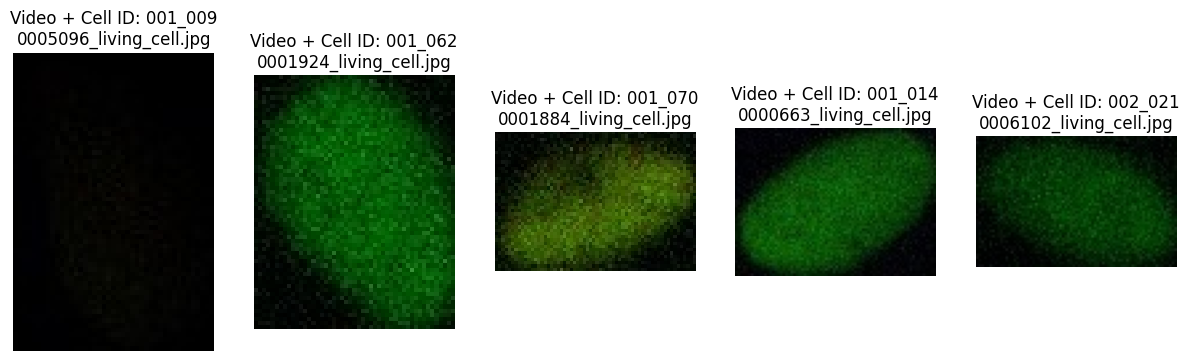

In [8]:
%matplotlib inline
# Collect all cropped cell image paths
crop_paths = list(CROP_DIR.rglob("*.jpg"))
# Randomly pick five example images
crop_examples = random.sample(crop_paths, 5)
# Plot the five images
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(crop_examples):
    # Load the current image
    img = cv2.imread(str(img_path))
    # Turn the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Create five consecutive subplots
    plt.subplot(1, 5, i+1)
    plt.imshow(img_rgb)
    # Print folder and image name
    plt.title("Video + Cell ID: " + img_path.parts[-2] + "\n" + img_path.name)
    plt.axis('off')
plt.show()

## Part 3: Train the appearance model of DeepSORT

In [9]:
# Initialize different values for hyperparameters for in-depth analysis
batch_sizes = [4, 8, 16, 32, 64] # Default: 32
lrs = [0.0001, 0.001, 0.01] # Default: 0.001
optimizer = ["sgd", "nesterov", "adam"] # Default: SGD

In [ ]:
# Train the appearance model through train.py of DeepSORT with different learning rates and optimizers
# Grid Search for two hyperparameters that interact strongly with each other; investigate impact of hyperparameters and find best performing pair
for lr in lrs:
    for opt in optimizer:
        print("---------------------------------------------------------------------------------")
        print(f"Model with batch size: {32}, epochs: {40}, learning rate: {lr}, optimizer: {opt}")
        # Initialize model name for train.jpg
        model_name = f"{opt}_lr{lr}_batch{32}"
        # Train the model
        print(model_name)
        !python deep_sort_pytorch/deep_sort/deep/train.py --data-dir cell_crops --lr {lr} --optimizer {opt} --model_name {model_name}

In [ ]:
# Manually select the best values for the learning rate and optimizer
best_lr = 0.001
best_opt = "sgd"

In [ ]:
# Train the appearance model through train.py of DeepSORT with different batch sizes
# Greedy Search for batch size with best performing learning rate + optimizer pair; investigate impact of batch size and find best performing one
for size in batch_sizes:
    print("---------------------------------------------------------------------------------")
    print(f"Model with batch size: {size}, epochs: {40}, learning rate: {best_lr}, optimizer: {best_opt}")
    # Initialize model name for train.jpg
    model_name = f"{best_opt}_lr{best_lr}_batch{size}"
    # Train the model
    !python deep_sort_pytorch/deep_sort/deep/train.py --data-dir cell_crops --batch_size {size} --lr {best_lr} --optimizer {best_opt} --model_name {model_name}

In [ ]:
# Manually select the best value for the batch size
best_batch_size = 32

In [ ]:
# Train the final appearance model with the best performing hyperparameters
# Use 60 epochs, find optimal epoch count and use that model for tracking with DeepSORT
print(f"Final model with batch size: {best_batch_size}, epochs: {60}, learning rate: {best_lr}, optimizer: {best_opt}")
# Initialize model name for train.jpg
model_name = f"final_version_{best_opt}_lr{best_lr}_batch{best_batch_size}"
# Train the model
!python deep_sort_pytorch/deep_sort/deep/train.py --data-dir cell_crops --epochs 60 --batch_size {best_batch_size} --lr {best_lr} --optimizer {best_opt} --model_name {model_name}

In [ ]:
# Visualize the automatically generated train + val loss plot
train_val_img = mpimg.imread(f"deep_sort_pytorch/deep_sort/deep/train_final_version_{best_opt}_lr{best_lr}_batch{best_batch_size}.jpg")
plt.imshow(train_val_img)
plt.axis('off')
plt.show()

## Part 4: SORT

### Prepare for SORT

In [10]:
DATASET_DIR = Path("dataset_jpg/dataset")
ANN_FILE = DATASET_DIR / "annotations.json"

with ANN_FILE.open("r") as f:
    coco = json.load(f)

img_by_id = {img["id"]: img for img in coco["images"]}
annots_by_frame = defaultdict(list)
for ann in coco["annotations"]:
    img_id = ann["image_id"]
    x_center, y_center, w, h = ann["bbox"]
    x1, y1 = x_center - w / 2, y_center - h / 2
    annots_by_frame[img_id].append([x1, y1, x1 + w, y1 + h, 1.0])  # [x1, y1, x2, y2, confidence]

### Run SORT Tracker on Test Sequences

In [11]:
tracker = Sort(max_age=5, min_hits=2, iou_threshold=0.3)

results = []
for folder in test_folders:
    folder_path = DATASET_DIR / folder / "images"
    frame_files = sorted(folder_path.glob("*.jpg"))  # Assumes images are .jpg
    print(f"Extracting images from {folder_path}")

    for frame_path in frame_files:
        img_name = frame_path.name
        img_info = next((img for img in coco["images"] if img["file_name"].endswith(img_name)), None)
        if not img_info:
            continue

        frame_id = img_info["id"]
        detections = np.array(annots_by_frame.get(frame_id, []))
        print(f"{frame_path.name}: {len(detections)} detections")

        if detections.size == 0:
            detections = np.empty((0, 5))

        tracked_objects = tracker.update(detections)
        for obj in tracked_objects:
            x1, y1, x2, y2, track_id = obj
            results.append({
                "frame": img_name,
                "track_id": int(track_id),
                "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                "video_id": folder
            })

Extracting images from dataset_jpg\dataset\003\images
xy003c0t001.jpg: 29 detections
xy003c0t002.jpg: 29 detections
xy003c0t003.jpg: 29 detections
xy003c0t004.jpg: 30 detections
xy003c0t005.jpg: 31 detections
xy003c0t006.jpg: 31 detections
xy003c0t007.jpg: 31 detections
xy003c0t008.jpg: 32 detections
xy003c0t009.jpg: 32 detections
xy003c0t010.jpg: 32 detections
xy003c0t011.jpg: 33 detections
xy003c0t012.jpg: 33 detections
xy003c0t013.jpg: 33 detections
xy003c0t014.jpg: 33 detections
xy003c0t015.jpg: 35 detections
xy003c0t016.jpg: 34 detections
xy003c0t017.jpg: 34 detections
xy003c0t018.jpg: 34 detections
xy003c0t019.jpg: 37 detections
xy003c0t020.jpg: 37 detections
xy003c0t021.jpg: 38 detections
xy003c0t022.jpg: 39 detections
xy003c0t023.jpg: 39 detections
xy003c0t024.jpg: 39 detections
xy003c0t025.jpg: 40 detections
xy003c0t026.jpg: 40 detections
xy003c0t027.jpg: 40 detections
xy003c0t028.jpg: 41 detections
xy003c0t029.jpg: 42 detections
xy003c0t030.jpg: 43 detections
xy003c0t031.jpg:

### Visualize results

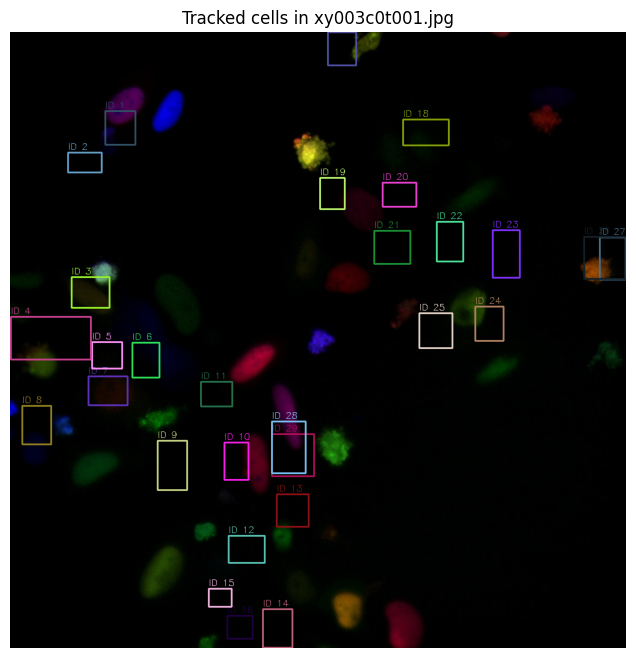

In [12]:
def draw_tracking_result(image, tracked_objects):
    for obj in tracked_objects:
        x1, y1, w, h = map(int, obj["bbox"])
        track_id = obj["track_id"]
        color = (track_id * 50 % 256, track_id * 80 % 256, track_id * 100 % 256)
        cv2.rectangle(image, (x1, y1), (x1 + w, y1 + h), color, 2)
        cv2.putText(image, f"ID {track_id}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

frame_to_vis = results[0]["frame"]
img = cv2.imread(str(DATASET_DIR / results[0]["video_id"] / frame_to_vis))
img = cv2.imread(str(frame_path))
if img is None:
    raise FileNotFoundError(f"❌ Failed to load image: {frame_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
objects_in_frame = [r for r in results if r["frame"] == frame_to_vis]
draw_tracking_result(img, objects_in_frame)

plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f"Tracked cells in {frame_to_vis}")
plt.show()

### Evaluating SORT

In [39]:
import json
import motmetrics as mm
from collections import defaultdict

# Load annotations
with open("dataset_jpg/dataset/annotations.json", "r") as f:
    coco = json.load(f)

In [40]:
# Group annotations by frame
gt_by_frame = defaultdict(list)  # frame_id -> list of (bbox, cell_id)
img_by_id = {img["id"]: img for img in coco["images"]}

for ann in coco["annotations"]:
    img_id = ann["image_id"]
    frame_id = int(img_by_id[img_id]["frame_id"])
    cell_id = int(ann["cell_id"])
    x, y, w, h = ann["bbox"]
    x0, y0, x1, y1 = x - w/2, y - h/2, x + w/2, y + h/2  # convert to corners
    gt_by_frame[frame_id].append(((x0, y0, x1, y1), cell_id))

In [41]:
pred_by_frame = defaultdict(list)

filename_to_frame_id = {}
for img in coco["images"]:
    file_name = img["file_name"].split("/")[2]
    filename_to_frame_id[file_name] = int(img["frame_id"])

for r in results:
    filename = r["frame"]
    if filename not in filename_to_frame_id:
        print(f"Warning: frame {filename} not found in annotations — skipping")
        continue

    frame_id = filename_to_frame_id[filename]
    track_id = int(r["track_id"])
    x, y, w, h = r["bbox"]
    x0, y0, x1, y1 = x - w / 2, y - h / 2, x + w / 2, y + h / 2

    pred_by_frame[frame_id].append(((x0, y0, x1, y1), track_id))

In [53]:
acc = mm.MOTAccumulator(auto_id=True)

all_frames = sorted(set(gt_by_frame.keys()) & set(pred_by_frame.keys()))
print(len(all_frames))
for frame_id in all_frames:
    gt_objs = gt_by_frame[frame_id]
    pred_objs = pred_by_frame[frame_id]

    gt_objs_processed = [ (bbox, int(id_)) for bbox, id_ in gt_objs ]
    pred_objs_processed = [ (bbox, int(id_)) for bbox, id_ in pred_objs ]

    gt_bboxes, gt_ids = zip(*gt_objs_processed) if gt_objs_processed else ([], [])
    pred_bboxes, pred_ids = zip(*pred_objs_processed) if pred_objs_processed else ([], [])

    # # --- ADD THESE PRINT STATEMENTS ---
    # print(f"--- Frame ID: {frame_id} ---")
    # print("GT IDs:")
    # for i, gt_id in enumerate(gt_ids):
    #     print(f"  ID: {gt_id}, Type: {type(gt_id)}")
    # print("Pred IDs:")
    # for i, pred_id in enumerate(pred_ids):
    #     print(f"  ID: {pred_id}, Type: {type(pred_id)}")
    # print("-" * 20)
    # # -----------------------------------

    # Convert IDs to native Python int to avoid KeyError in motmetrics
    # gt_ids = [int(id_) for id_ in gt_ids]
    # pred_ids = [int(id_) for id_ in pred_ids]

    # Convert to numpy arrays
    gt_bboxes = np.array(gt_bboxes)
    pred_bboxes = np.array(pred_bboxes)

    # Compute IoU distance
    def iou(bbox1, bbox2):
        """bbox format: (x0, y0, x1, y1)"""
        inter_x0 = np.maximum(bbox1[0], bbox2[0])
        inter_y0 = np.maximum(bbox1[1], bbox2[1])
        inter_x1 = np.minimum(bbox1[2], bbox2[2])
        inter_y1 = np.minimum(bbox1[3], bbox2[3])
        inter_area = np.maximum(0, inter_x1 - inter_x0) * np.maximum(0, inter_y1 - inter_y0)

        area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
        area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
        union_area = area1 + area2 - inter_area
        return inter_area / union_area if union_area > 0 else 0

    # Create IoU matrix (distance = 1 - IoU)
    if len(gt_bboxes) > 0 and len(pred_bboxes) > 0:
        iou_matrix = np.zeros((len(gt_bboxes), len(pred_bboxes)))
        for i, gt_box in enumerate(gt_bboxes):
            for j, pred_box in enumerate(pred_bboxes):
                iou_matrix[i, j] = 1 - iou(gt_box, pred_box)
    else:
        iou_matrix = np.ones((len(gt_bboxes), len(pred_bboxes)))  # all misses

    print(type(gt_ids))
    print(type(pred_ids))
    print(type(iou_matrix))
    acc.update(
        gt_ids,
        pred_ids,
        iou_matrix
    )

# Compute and print metrics
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=['mota', 'idf1', 'num_switches', 'recall', 'precision'], name='SORT')
print(mm.io.render_summary(summary, formatters=mh.formatters, namemap=mm.io.motchallenge_metric_names))

150
<class 'tuple'>
<class 'tuple'>
<class 'numpy.ndarray'>


KeyError: np.int64(1)